# A Classification Model for Municipalities in the Paraense Amazon Regarding the Risk of Domestic Violence Against Women: A Multicriteria Approach:

## 1. Import the names of the municipalities in the surveyed region:


`url` is the API request string. It follows the criteria defined in the API documentation that can be accessed through this link.

`res` is the variable that receives the API data (`json`).

`df_munic` is the main dataframe where the data obtained from the API will be structured.

In [60]:
import pandas as pd
import requests as rq

url = 'https://servicodados.ibge.gov.br/api/v1/localidades/estados/pa/municipios'
   
res = rq.request("GET", url)

#Creates a data frame with the Municipalities column.
if res.status_code == 200:
    df_munic = pd.DataFrame({'id': [], 'localidade': []})
    
    for id, munic in enumerate(res.json()):
        df_munic.loc[id] = [str(munic['id'])[:6], munic['nome']]

### 1.1. - Setting up the URL for getting the data and defining the main dataframe

With the help of the IBGE API documentation, we can obtain the code of the indicators we want to select. For the case study of the project, we selected the following indicators:

    90201: 'Has_specialized_delegations',
    90335: 'Executes specific_programs_actions
    90358: 'Has specific_legislation_violence_against_women
    90626:'Has rights_or_policies_for_women
    90640:'Has_human_rights_protection_programs_for_women_victims
    

In [61]:
indicators = ['90201','90335','90358','90626','90640']

url = "https://servicodados.ibge.gov.br/api/v1/pesquisas/1/periodos/2019/indicadores/"

# Adding indicators to the end of the url
for i, ind in enumerate(indicators):
    if i != (len(indicators)-1):
        url += ind + '|'
    else:
        url += ind + '/'
        
# Function to Formatting final url
def urlResultadosPorMunicipos(url, df):
    url += 'resultados/'    

    for i, row in df_munic.iterrows():
        if i != (len(df)-1):
            url += row.id + '|'
        else:
            url += row.id + '/'
    
    return url


url = urlResultadosPorMunicipos(url, df_munic)

# return json results
res = rq.request("GET", url)


## 2. Obtaining data from the protection and assistance network of each municipality.

In [62]:
if res.status_code == 200:
    
    #Scrolls through the json and inserts the data into the main dataframe for each selected indicator.
    for indicador in res.json():
        df_temp = pd.DataFrame(indicador['res'])
        df_temp = df_temp[['localidade', 'res']]
        df_temp.rename(columns = {'localidade':'id', 'res': indicador['id']}, inplace = True)
        
        #It replaces the words "Yes" and "No" with binary information 1 and 0.
        df_temp[indicador['id']] = df_temp[indicador['id']].map(lambda x: 1 if x['2019']  == 'Sim' else 0)
        df_munic = pd.merge(df_munic, df_temp, on="id")

##### 2.1 - It defines the number of women's protection and assistance mechanisms and aggregates the data to the main dataframe.

In [63]:
df_munic['Rede_de_Protecao_assistencia'] = df_munic[90201] + df_munic[90335] + df_munic[90358] + df_munic[90626] + df_munic[90640]
df_munic = df_munic[['id', 'localidade', 'Rede_de_Protecao_assistencia']]

## 3. Obtaining values for the Human Development Index (HDI)

In [64]:
url = "https://servicodados.ibge.gov.br/api/v1/pesquisas/37/periodos/2010/indicadores/30255/"

url = urlResultadosPorMunicipos(url, df_munic)
        
res = rq.request("GET", url)

# correction of missing values
x = res.json()
x[0]['res'][73]['res']['2010'] = '0'
x

df_temp = pd.json_normalize(x[0]['res'])
df_temp.rename(columns={'localidade': 'id', 'res.2010': 'IDH'}, inplace=True)
df_temp = df_temp[['id', 'IDH']]
df_munic = pd.merge(df_munic, df_temp, on='id')

## 4. Getting Per Capita Income

In [65]:
url = "https://servicodados.ibge.gov.br/api/v1/pesquisas/38/periodos/2019/indicadores/47001/"

url = urlResultadosPorMunicipos(url, df_munic)   
res = rq.request("GET", url)
df_temp = pd.json_normalize(res.json()[0]['res'])
df_temp.rename(columns={'localidade': 'id', 'res.2019': 'PIB'}, inplace=True)
df_temp = df_temp[['id', 'PIB']]
df_munic = pd.merge(df_munic, df_temp, on='id')

## 5. Getting GINI Index

In [66]:
url = "https://servicodados.ibge.gov.br/api/v1/pesquisas/36/periodos/2003/indicadores/30252/"

url = urlResultadosPorMunicipos(url, df_munic)
        
res = rq.request("GET", url)
# correction of missing values
x = res.json()
x[0]['res'].append({'localidade': '150475', 'res': {'2003': '0.00'}, 'notas': {'2003': None}})

df_temp = pd.json_normalize(x[0]['res'])
df_temp.rename(columns={'localidade': 'id', 'res.2003': 'GINI'}, inplace=True)
df_temp = df_temp[['id', 'GINI']]
df_munic = pd.merge(df_munic, df_temp, on='id', how='left')

#### ✔ Turning Columns into Numeric Types

In [67]:
df_munic['Rede_de_Protecao_assistencia'] = pd.to_numeric(df_munic['Rede_de_Protecao_assistencia'])
df_munic['IDH'] = pd.to_numeric(df_munic['IDH'])
df_munic['PIB'] = pd.to_numeric(df_munic['PIB'])
df_munic['GINI'] = pd.to_numeric(df_munic['GINI'])

# 6. Data Normalization

Normalization consists in recalculating the values of the columns for intervals between 0 and 1. This procedure is necessary so that different scales do not affect the accuracy of the model. In this case, only the columns that have values with scales outside the range 0 and 1 will be recalculated.
The calculation is done by dividing the value of the alternative by the sum of the column values:

![](https://cdn-images-1.medium.com/max/253/1*Dl3P3Rrzto258X0Ales9Xw.png)


In [68]:
cols = df_munic[['IDH', 'PIB', 'GINI']]

def normalize(df_columns):
    for i in df_columns:
        mx = df_munic[[i]].max()[0]
        mn = df_munic[[i]].min()[0]
        df_munic[[i]] = (df_munic[[i]] - mn) / (mx - mn)

def deNormalize(df_columns, dmin, dmax):
    for i in df_columns:
        df_munic[[i]] = df_munic[[i]] * (dmax - dmin) + dmin

normalize(cols)

# 7. Application of the Multicriteria Method ELECTRE Tri-b

### pyDecision library installation

```python 
    pip install pyDecision
```

### Classification parameter settings

In [69]:
     #IP       #IDH      #PIB      #GINI
Q = [0.2,      0.10,      0.1,      0.1]
P = [0.5,      0.20,      0.2,      0.2]
V = [0.6,      1.00,      1.0,      1.0]
W = [0.50,     1.00,      0.30,      1.0]

B = [[0,       0.48,      0.01,     0.37],
     [1,       0.57,      0.03,     0.68],
     [2,       0.62,      0.04,     0.70],
     [3,       0.68,      0.08,     0.72],
     [4,       0.69,      0.50,     0.85]]

# 8. Run Classification by PyDecision Library

In [70]:
# Require Library
import numpy as np
from pyDecision.algorithm import electre_tri_b

def classification_electre_tri_b():
    # Creating a numpy object from main DataFrame
    columns = df_munic[['Rede_de_Protecao_assistencia', 'IDH', 'PIB', 'GINI']]
    data = pd.DataFrame(columns).to_numpy()

    # Call Electre Tri-B Function
    return data, electre_tri_b(data, W , Q , P , V , B, cut_level = 0.60, verbose = False, rule = 'pc', graph = False)

dataset1, classification = classification_electre_tri_b()

In [71]:
#Create a new DataFrame(xd) with classification results data to merge main DataFrame (df_munic)
d = []
for i in range(0, len(classification)):
     d.append({'ID': 'x' + str(i+1), 'Class': str(classification[i])})

xd = pd.DataFrame(d)

df_munic['idx'] = xd['ID']
df_munic['classe'] = pd.to_numeric(xd['Class'])

## 8.1 Plotting Classification Graphic

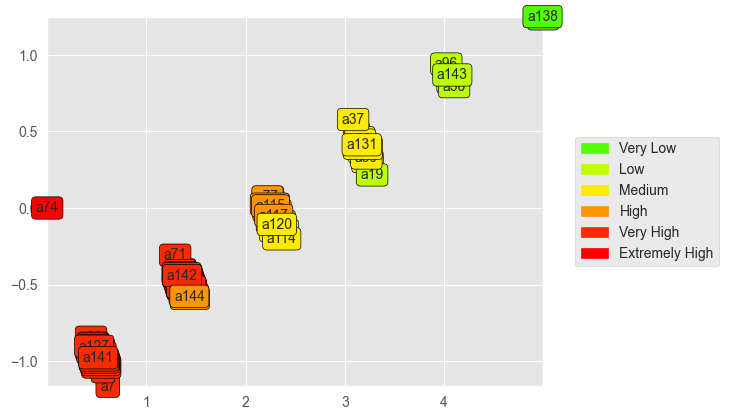

In [72]:
### - - - - - - - - - - - - - - - - - - - - - - - - ####
#                                                      #
#       Adapted code from the PyDecision library       #
#                                                      #
### - - - - - - - - - - - - - - - - - - - - - - - - ####

import copy
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

classification
plt.style.use('ggplot')

colors = {'Very Low':'#54FF00', 'Low':'#BDFF00', 'Medium':'#FFEB00', 'High':'#FF9500', 'Very High':'#FF2A00', 'Extremely High':'#FF0000', 'G':'#04d8b2', 'H':'#ffb07c', 'I':'#aaa662', 'J':'#0485d1', 'K':'#fffe7a', 'L':'#b0dd16', 'M':'#85679', 'N':'#12e193', 'O':'#82cafc', 'P':'#ac9362', 'Q':'#f8481c', 'R':'#c292a1', 'S':'#c0fa8b', 'T':'#ca7b80', 'U':'#f4d054', 'V':'#fbdd7e', 'W':'#ffff7e', 'X':'#cd7584', 'Y':'#f9bc08', 'Z':'#c7c10c'}
classification_ = copy.deepcopy(classification)
color_leg = {}
if (dataset1.shape[1] == 2):
    data_proj = np.copy(dataset1)
else:
    tSVD      = TruncatedSVD(n_components = 2, n_iter = 100, random_state = 42)
    tSVD_proj = tSVD.fit_transform(dataset1)
    data_proj = np.copy(tSVD_proj)

class_list  = list(set(classification_))
for i in range(0, len(classification_)):
    classification_[i] = str(classification_[i])
for i in range(0, len(classification_)):
    for j in range(0, len(class_list)):
        classification_[i] = classification_[i].replace(str(class_list[j]), str(chr(ord('A') + class_list[j])))
class_list = list(set(classification_))
class_list.sort() 
list_replace = {'A': 'Very Low', 'B': 'Low', 'C': 'Medium', 'D': 'High', 'E': 'Very High', 'F': 'Extremely High'}
classification__ = []
for i in range(0, len(classification_)):
    classification__.append(list_replace[classification_[i]])
class_list_ = ['Very Low', 'Low', 'Medium', 'High', 'Very High', 'Extremely High']
for i in range(0, len(class_list_)):
    color_leg[class_list_[i]] = colors[class_list_[i]]
patchList = []
for key in color_leg:
    data_key = mpatches.Patch(color = color_leg[key], label = key)
    patchList.append(data_key)
for i in range(0, data_proj.shape[0]):
    plt.text(data_proj[i, 0], data_proj[i, 1], 'a' + str(i+1), size = 10, ha = 'center', va = 'center', bbox = dict(boxstyle = 'round', ec = (0.0, 0.0, 0.0), fc = colors[classification__[i]],))
plt.gca().legend(handles = patchList, loc = 'center left', bbox_to_anchor = (1.05, 0.5))
axes = plt.gca()
xmin = np.amin(data_proj[:,0])
xmax = np.amax(data_proj[:,0])
axes.set_xlim([xmin*0.7, xmax*1])
ymin = np.amin(data_proj[:,1])
ymax = np.amax(data_proj[:,1])
if (ymin < ymax):
    axes.set_ylim([ymin, ymax])
else:
    axes.set_ylim([ymin*0.7, ymax*1])
plt.show()


In [73]:
     #IP       #IDH      #PIB      #GINI
Q = [0.1,      0.10,      0.1,      0.1]
P = [0.2,      0.20,      0.2,      0.2]
V = [1.0,      1.00,      1.0,      1.0]
W = [0.5,      1.00,      0.3,      1.0]

B = [[0.1,       0.48,      0.01,     0.37],
     [0.2,       0.57,      0.03,     0.68],
     [0.3,       0.62,      0.04,     0.70],
     [0.4,       0.68,      0.08,     0.72],
     [0.5,       0.69,      0.50,     0.85]]

col = df_munic[['Rede_de_Protecao_assistencia']]

normalize(col)

dataset1, classification = classification_electre_tri_b()

### -- List Classification Cities

In [74]:
df_munic[['localidade', 'classe']].sort_values(by=['classe'])

,localidade,classe
137,Tucuruí,0
17,Barcarena,0
65,Marabá,0
0,Abaetetuba,1
33,Capanema,1
...,...,...
55,Ipixuna do Pará,4
25,Brejo Grande do Araguaia,4
87,Palestina do Pará,4
53,Igarapé-Miri,4


# 9. Plotting Results on the map.

#### - Get GeoPandas library for mapping Para's municipalities
#### - Reading the file with the state geometry

In [75]:
import geopandas as gpd

gdf_munic = gpd.read_file('munics.geojson')

for value in gdf_munic['id']:
    gdf_munic['id'].replace(to_replace=value, value=value[:6], regex=True,inplace=True)


df_teste = pd.merge(df_munic, gdf_munic, on='id', how='left')

df_teste = df_teste[['id', 'localidade', 'geometry']]

df_teste['classe'] = classification

### To the map

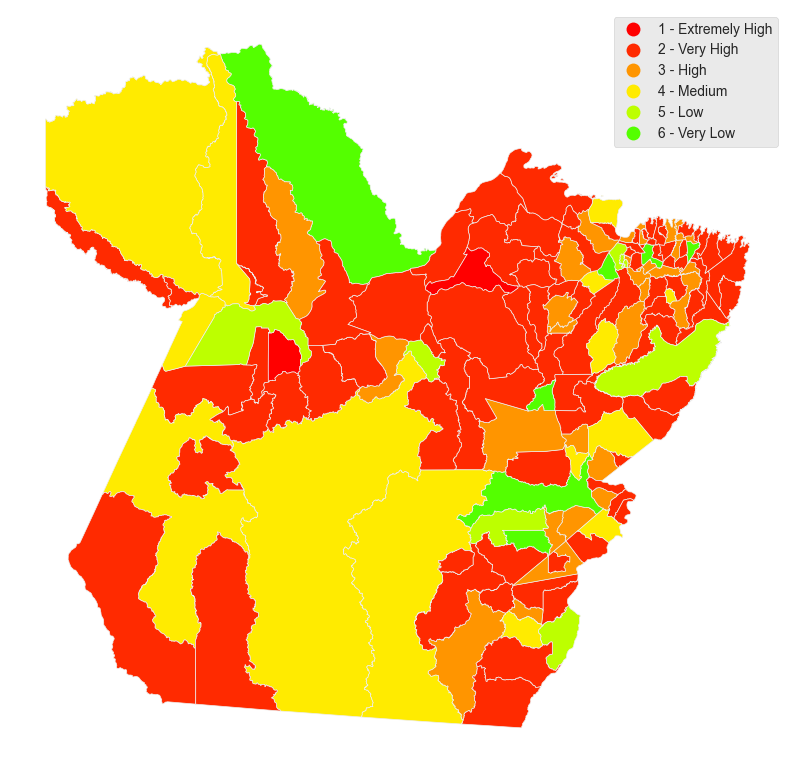

In [76]:
clusdict={5: '1 - Extremely High', 4: '2 - Very High', 3: '3 - High', 2: '4 - Medium', 1: '5 - Low', 0: '6 - Very Low' }
df_teste['legenda'] = df_teste['classe'].map(clusdict)
df_teste['classe'] = classification

gpd_teste = gpd.GeoDataFrame(df_teste)

ax = gpd_teste.plot(column='legenda', categorical=True, legend=True, legend_kwds={'loc': 'upper right'}, figsize=(10,10), cmap='prism')

def replace_legend_items(legend, mapping):
    for txt in legend.texts:
        for k,v in mapping.items():
            if txt.get_text() == str(k):
                txt.set_text(v)

replace_legend_items(ax.get_legend(), clusdict)

ax.set_axis_off()

### Obtaining number of denunciations per municipality
#### Source: Ministry of Women, Family and Human Rights (https://www.gov.br/mdh/pt-br/acesso-a-informacao/dados-abertos/ligue180)

In [77]:
dd = pd.read_json('casos_violencia_por_municipio.json')
df_munic['denuncias'] = dd['casos']

### Showing visualization between public equipment index and the number of reports

[Text(0.5, 0, 'Support and Protection Index (IAP)'),
 Text(0, 0.5, 'Denunciations')]

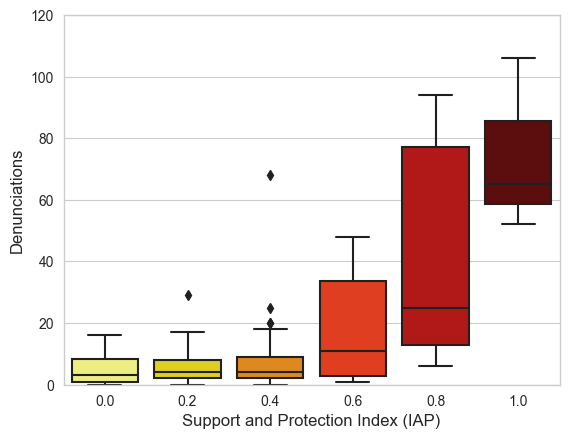

In [78]:
import seaborn as sns 
import matplotlib.pyplot as plt

data = df_munic

import seaborn as sns
sns.set_style("whitegrid")
 
# depict visualization
gfg = sns.boxplot(x="Rede_de_Protecao_assistencia", y="denuncias",
                  data=data, palette='hot_r')

gfg.set_ylim(0, 120)
gfg.set(xlabel ="Support and Protection Index (IAP)", ylabel = "Denunciations")